In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
import albumentations.pytorch
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from tqdm import tqdm

import wandb

config={
    "lr": 1.8e-4,
    "dropout": 0.5,
    "architecture": "Efficientb6 + 3way",
    "dataset": "mask + age",
    "augmentation" : "On Runtime",
    "age_weightedloss" : [1.0, 1.0, 1.0],
    "gender_weightedloss" : [1.4, 1.0],
    "gamma" : 0.85,
    "batch_size" : 32
}

wandb.init(project="MaskClassification", config=config)



wandb: Currently logged in as: youkind (use `wandb login --relogin` to force relogin)

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



In [2]:
print('CUDA GPU available : {}'.format(torch.cuda.is_available()))
try:
    print('{} GPU(s) is(are) allocated'.format(torch.cuda.device_count()))
except:
    print('GPUs are not allocated. Current runtime is on CPU.')
device = torch.device("cuda")
CUDA_LAUNCH_BLOCKING=1

CUDA GPU available : True
1 GPU(s) is(are) allocated


In [3]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'
train_dir = '/opt/ml/input/data/train'

labels_to_class = {}
it = [(m, g, a) for m in [0,1,2] for g in [0, 1] for a in [0, 1, 2]]
for i, (m, g, a) in enumerate(it):
    labels_to_class[(m, g, a)] = i

## Dataset

In [4]:
class TrainDataset(Dataset):
    def __init__(self, train_dir, is_Train=True, transform=None):
        super().__init__()
        
        csv_path = os.path.join(train_dir, 'train.csv')
        csv = pd.read_csv(csv_path)
        self.image_dir = os.path.join(train_dir, 'images')
        self.transform = transform
        self.image_path = []
        path = csv['path']
        
        for p in path:
            images = [os.path.join(*[self.image_dir, p, image]) for image in os.listdir(os.path.join(self.image_dir, p)) if not image[:1] == '.']
            for image in images:
                self.image_path.append(image)

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image_name = self.image_path[idx]
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        features = image_name.split('/')[-2:]
        
        masktoint = {'m' : 0, 'i' : 1, 'n' : 2}
        gendertoint = {'male' : 0, 'female' : 1}
        
        mask = masktoint[features[1][0]]
        age = int(features[0].split('_')[-1])
        gender = gendertoint[features[0].split('_')[1]]
        
        if age >= 60: # 원래 60
            age = 2
        elif age >= 30: # 원래 30
            age = 1
        else:
            age = 0        
        
        if self.transform:
            image = self.transform(image=image)['image']
        
        return image, (mask, gender, age)

class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = cv2.imread(self.img_paths[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image

    def __len__(self):
        return len(self.img_paths)

In [5]:
from torch.utils.data.dataset import random_split
tfms = A.Compose([
        A.augmentations.crops.transforms.CenterCrop(400, 300, p=1.0),
        A.augmentations.geometric.resize.Resize(224, 224, interpolation=1, p=1),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.6),
        A.RandomBrightnessContrast(brightness_limit=0.1, p=0.6),
        A.GaussNoise(p=0.5),
        A.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
        A.pytorch.transforms.ToTensorV2(),
    ])
tfms_test = A.Compose([
        A.augmentations.crops.transforms.CenterCrop(400, 360, p=1.0),
        A.augmentations.geometric.resize.Resize(224, 224, interpolation=1, p=1),
        A.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
        A.pytorch.transforms.ToTensorV2(),
    ])
dataset = TrainDataset(train_dir, transform=tfms)
train_dataset, val_dataset = random_split(dataset, [int(len(dataset)*0.8),int(len(dataset)*0.2)])
# print(len(dataset))
# plt.imshow(np.array(train_dataset[312][0]['image'].permute(1,2,0)))
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4, drop_last=False)
val_loader   = DataLoader(dataset=val_dataset, num_workers=4, batch_size=config['batch_size'])

In [6]:
# plt.imshow(np.array(train_dataset[312][0]['image'].permute(1,2,0)))

## Model

In [7]:
from efficientnet_pytorch import EfficientNet

class Way3(nn.Module):
    def __init__(self):
        super().__init__()
        self.convnet = EfficientNet.from_pretrained('efficientnet-b6', num_classes=1024).to(device)
        self.mask = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=config['dropout'], inplace=False),
            nn.Linear(1024, 128),
            nn.LeakyReLU(),
            nn.Dropout(p=config['dropout'], inplace=False),
            nn.Linear(128, 3),
            nn.Softmax(dim=1)
        )
        self.gender = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=config['dropout'], inplace=False),
            nn.Linear(1024, 128),
            nn.LeakyReLU(),
            nn.Dropout(p=config['dropout'], inplace=False),
            nn.Linear(128, 2),
            nn.Softmax(dim=1)
        )
        self.age = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=config['dropout'], inplace=False),
            nn.Linear(1024, 128),
            nn.LeakyReLU(),
            nn.Dropout(p=config['dropout'], inplace=False),
            nn.Linear(128, 3),
            nn.Softmax(dim=1)
        )
        self.best_f1 = 0
        
    def forward(self, x):
        features = self.convnet(x)
        mask = self.mask(features)
        gender = self.gender(features)
        age = self.age(features)
        
        return mask, gender, age
    
model = Way3().to(device)

Loaded pretrained weights for efficientnet-b6


In [8]:
import torch.optim as optim

w_gender = torch.tensor(config['gender_weightedloss']).to(device)
w_age = torch.tensor(config['age_weightedloss']).to(device)

criterion = nn.CrossEntropyLoss()
gender_criterion = nn.CrossEntropyLoss(w_gender)
age_criterion = nn.CrossEntropyLoss(weight=w_age)
# b_criterion = nn.BCEWithLogitsLoss()
# criterion = FocalLoss()
optimizer = optim.AdamW(model.parameters(), lr=config['lr'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=config['gamma'], verbose=True)

Adjusting learning rate of group 0 to 1.8000e-04.


In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def check(loader, length, model, device):
    model.eval()
    val_loss = 0.0
    counter = 0
    y_true = []
    y_predicted = []

    m_acc = []
    g_acc = []
    a_acc = []
    with torch.no_grad():
        for (inputs, (m, g, a)) in val_loader:
            counter += 1
            
            for mask, gender, age in zip(m, g, a):
                answer = labels_to_class[(mask.item(), gender.item(), age.item())]
                y_true.append(answer)
            
            inputs = inputs.to(device=device)
            m = m.to(device)
            g = g.to(device)
            a = a.to(device)

            m_pred, g_pred, a_pred = model(inputs)
    
            m_loss = criterion(m_pred, m)
            g_loss = gender_criterion(g_pred, g)
            a_loss = age_criterion(a_pred, a) # data imbalance
            
            loss = (g_loss+a_loss+m_loss)
            
            val_loss += loss.item()
            
            m_argmax = m_pred.detach().cpu().numpy().argmax(1)
            g_argmax = g_pred.detach().cpu().numpy().argmax(1)
            a_argmax = a_pred.detach().cpu().numpy().argmax(1)

            m_acc.append(accuracy_score(m_argmax, m.detach().cpu().numpy()))
            g_acc.append(accuracy_score(g_argmax, g.detach().cpu().numpy()))
            a_acc.append(accuracy_score(a_argmax, a.detach().cpu().numpy()))

            for mask, gender, age in zip(m_argmax, g_argmax, a_argmax):
                predicted = labels_to_class[(mask.item(), gender.item(), age.item())]
                y_predicted.append(predicted)
    
    
    cm = confusion_matrix(y_true, y_predicted)
    F1 = []
    for c in range(18):
        precision = cm[c][c] / np.sum(cm, axis=0)[c]
        recall = cm[c][c] / np.sum(cm, axis=1)[c]
        F1.append(2 * precision * recall / (precision + recall))
    macro_F1 = np.mean(F1)

    s = 0
    for c in range(18):
        s += cm[c][c]
        
    print("< VALIDATION >")
    print("*"*73)
    print("Validation Loss :", val_loss/counter)
    print("-"*73)
    print("Total Accuracy")
    print(s / length * 100, "%")
    print("-"*73)
    print("Class Accuracy")
    print("Mask   :", np.mean(m_acc)*100, "%")
    print("Gender :", np.mean(g_acc)*100, "%")
    print("Age    :", np.mean(a_acc)*100, "%")
    print("-"*73)
    print("Confusion Matrix")
    for row in cm:
        print(row)
    print("-"*73)
    print("Validation F1 score :" , macro_F1)
    if model.best_f1 < macro_F1:
        model.best_f1 = macro_F1
        torch.save(model.state_dict(), '/opt/ml/weights/3way_age/Aug_{}.pt'.format(model.best_f1))
        print("model saved!")
    print("*"*73)
    print()
    wandb.log({
        "Validation Loss" : val_loss/counter, 
        "Validation Total Accuracy" : s / length *100, 
        "Validation F1" : macro_F1,
        "Mask Accuracy" : np.mean(m_acc)*100,
        "Gender Accuracy" : np.mean(g_acc)*100,
        "Age Accuracy" : np.mean(a_acc)*100,
    })
        
    model.train()

In [10]:
NUM_EPOCHS = 15

for epoch in range(NUM_EPOCHS):
    print("Epoch :", epoch + 1)
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    total_it = int(len(train_dataset)/train_loader.batch_size)
    prog_bar = tqdm(enumerate(train_loader), total=total_it)
    for i, (inputs, (m, g, a)) in prog_bar:
        counter += 1
        optimizer.zero_grad()
        inputs = inputs.to(device)
        m_pred, g_pred, a_pred = model(inputs)
        
        
        m = m.to(device)
        g = g.to(device)
        a = a.to(device)
        total += m.size(0)
        
        m_loss = criterion(m_pred, m)
        g_loss = gender_criterion(g_pred, g)
        a_loss = age_criterion(a_pred, a) # data imbalance
        
        
        loss = (g_loss+a_loss+m_loss)
        loss.backward()
        optimizer.step()
        
        
        train_running_loss += loss.item()
        
        if i == total_it//2 or i == total_it-1:
            train_loss = train_running_loss / counter
#             train_accuracy = 100. * train_running_correct / total

            print("Loss :", train_loss)
            wandb.log({"Train Loss" : train_loss})
#             print("Accuracy :", train_accuracy)
            
            check(val_loader, len(val_dataset), model, device)
    scheduler.step()
    train_running_loss = 0.0
    train_running_correct = 0
print("Finish")

Epoch : 1


 50%|█████     | 686/1372 [05:09<05:07,  2.23it/s]

Loss : 1.7252948603428782
< VALIDATION >
*************************************************************************
Validation Loss : 1.531939564749252
-------------------------------------------------------------------------
Total Accuracy
88.42440801457195 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.42768895348837 %
Gender : 97.89244186046511 %
Age    : 90.73401162790698 %
-------------------------------------------------------------------------
Confusion Matrix
[577   4   0   3   1   0   2   0   0   0   0   0   0   0   0   0   0   0]
[ 55 357   6   1  21   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  9 114 398   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[ 17   0   0 676   6   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  5   5   0  66 718  23   0   0   0   0   1   0   0   0   0   0   0   0]
[  0   0   2   1  73 603   0   0   0   0   1   2   0   0   0   0   0   0]
[  5   0   0   0   0   0 504 

 50%|█████     | 687/1372 [05:47<2:13:02, 11.65s/it]

model saved!
*************************************************************************



100%|█████████▉| 1371/1372 [10:54<00:00,  2.23it/s] 

Loss : 1.635667941399983
< VALIDATION >
*************************************************************************
Validation Loss : 1.496394042358842
-------------------------------------------------------------------------
Total Accuracy
91.77595628415301 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.609375 %
Gender : 98.17405523255815 %
Age    : 93.77725290697676 %
-------------------------------------------------------------------------
Confusion Matrix
[571   6   0   0   2   0   8   0   0   0   0   0   0   0   0   0   0   0]
[ 26 333  74   0   5   0   0   2   0   0   0   0   0   0   0   0   0   0]
[  3   8 505   0   0   0   0   0   5   0   0   0   0   0   0   0   0   0]
[ 22   2   0 604  68   0   0   0   0   3   0   0   0   0   0   0   0   0]
[  3  21   0   3 772  17   0   0   0   0   2   0   0   0   0   0   0   0]
[  0   0   6   0  33 633   0   0   0   0   0  10   0   0   0   0   0   0]
[  0   0   0   0   0   0 510   3   0  

100%|██████████| 1372/1372 [11:32<00:00, 11.61s/it]

model saved!
*************************************************************************



1373it [11:32,  1.98it/s]                          

Adjusting learning rate of group 0 to 1.5300e-04.
Epoch : 2



 50%|█████     | 686/1372 [05:09<05:08,  2.23it/s]

Loss : 1.5077666799053875
< VALIDATION >
*************************************************************************
Validation Loss : 1.4786468553681706
-------------------------------------------------------------------------
Total Accuracy
93.75227686703097 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.76380813953489 %
Gender : 99.09156976744185 %
Age    : 94.7765261627907 %
-------------------------------------------------------------------------
Confusion Matrix
[579   3   0   2   0   0   2   0   0   0   0   0   1   0   0   0   0   0]
[ 88 328  21   0   1   0   0   2   0   0   0   0   0   0   0   0   0   0]
[  5  13 495   0   0   5   0   0   0   0   0   0   0   0   3   0   0   0]
[  9   0   0 683   6   0   0   0   0   1   0   0   0   0   0   0   0   0]
[  3   9   0  37 737  31   0   0   0   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   7 670   0   0   0   0   0   5   0   0   0   0   0   0]
[  0   0   0   0   0   0 510 

 50%|█████     | 687/1372 [05:47<2:13:51, 11.72s/it]

model saved!
*************************************************************************



100%|█████████▉| 1371/1372 [10:55<00:00,  2.23it/s] 

Loss : 1.4976216162780283
< VALIDATION >
*************************************************************************
Validation Loss : 1.461128329468328
-------------------------------------------------------------------------
Total Accuracy
95.41894353369763 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.71838662790698 %
Gender : 99.43677325581395 %
Age    : 96.22093023255815 %
-------------------------------------------------------------------------
Confusion Matrix
[577   6   0   2   1   0   0   0   0   0   0   0   1   0   0   0   0   0]
[ 38 374  24   0   3   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0   7 513   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0]
[  9   0   0 683   6   0   0   0   0   1   0   0   0   0   0   0   0   0]
[  0   1   0  44 754  18   0   0   0   0   1   0   0   0   0   0   0   0]
[  0   0   0   0  19 663   0   0   0   0   0   0   0   0   0   0   0   0]
[  1   0   0   0   0   0 501 

100%|██████████| 1372/1372 [11:33<00:00, 11.49s/it]

model saved!
*************************************************************************



1373it [11:33,  1.98it/s]                          

Adjusting learning rate of group 0 to 1.3005e-04.
Epoch : 3



 50%|█████     | 686/1372 [05:09<05:07,  2.23it/s]

Loss : 1.4718007902564614
< VALIDATION >
*************************************************************************
Validation Loss : 1.4522448532110037
-------------------------------------------------------------------------
Total Accuracy
96.40255009107467 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.88190406976744 %
Gender : 99.53670058139535 %
Age    : 96.95675872093024 %
-------------------------------------------------------------------------
Confusion Matrix
[574   5   0   5   1   0   2   0   0   0   0   0   0   0   0   0   0   0]
[ 18 389  30   0   2   0   0   1   0   0   0   0   0   0   0   0   0   0]
[  0   1 520   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  6   0   0 650  41   1   0   0   0   1   0   0   0   0   0   0   0   0]
[  0   1   0   1 795  20   0   0   0   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   0 681   0   0   0   0   0   0   0   0   0   0   0   1]
[  0   0   0   0   0   0 508

 50%|█████     | 687/1372 [05:47<2:14:42, 11.80s/it]

model saved!
*************************************************************************



100%|█████████▉| 1371/1372 [10:55<00:00,  2.24it/s] 

Loss : 1.4701544142846812


100%|██████████| 1372/1372 [11:33<00:00, 11.62s/it]

< VALIDATION >
*************************************************************************
Validation Loss : 1.467521645648535
-------------------------------------------------------------------------
Total Accuracy
94.9544626593807 %
-------------------------------------------------------------------------
Class Accuracy
Mask   : 99.70930232558139 %
Gender : 99.51853197674419 %
Age    : 95.62136627906976 %
-------------------------------------------------------------------------
Confusion Matrix
[571   4   0   9   1   0   2   0   0   0   0   0   0   0   0   0   0   0]
[ 21 398  16   3   0   0   0   2   0   0   0   0   0   0   0   0   0   0]
[  0   3 518   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  6   0   0 678  15   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  0   2   0  53 733  29   0   0   0   0   1   0   0   0   0   0   0   0]
[  0   0   0   0   3 678   0   0   0   0   0   1   0   0   0   0   0   0]
[  4   0   0   0   0   0 496   6   0   9   0   0   1   0

1373it [11:33,  1.98it/s]                          

Adjusting learning rate of group 0 to 1.1054e-04.
Epoch : 4



 11%|█         | 145/1372 [01:06<09:18,  2.20it/s]


KeyboardInterrupt: 

## Testing

In [11]:
model.load_state_dict(torch.load('/opt/ml/weights/3way_age/Aug_{}.pt'.format(model.best_f1)))
# model.load_state_dict(torch.load('/opt/ml/weights/3way/Aug_0.9841404744270768.pt'.format(model.best_f1)))

<All keys matched successfully>

In [ ]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
dataset = TestDataset(image_paths, tfms_test)

loader = DataLoader(
    dataset,
    shuffle=False,
    batch_size=64,
    num_workers=4
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
# device = torch.device('cuda')

model.eval()
device = torch.device("cuda:0")
# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []

prog_bar = tqdm(enumerate(loader), total=int(len(dataset)/loader.batch_size))
for i, images in prog_bar:
    with torch.no_grad():
        images = images.to(device)
        m_pred, g_pred, a_pred = model(images)
#         print(images.shape)
#         print(m_pred.shape)
        m_argmax = m_pred.detach().cpu().numpy().argmax(1)
        g_argmax = g_pred.detach().cpu().numpy().argmax(1)
        a_argmax = a_pred.detach().cpu().numpy().argmax(1)
        
        for mask, gender, age in zip(m_argmax, g_argmax, a_argmax):
            predicted = labels_to_class[(mask.item(), gender.item(), age.item())]
            all_predictions.append(predicted)
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

Normal : 50.10339021682739 %
Female : 93.00719499588013 %
30 ~ 60 : 48.86142015457153 %


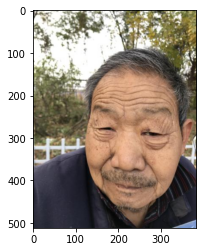

In [20]:
idx = 2
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image = cv2.imread(image_paths[idx])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

image = tfms_test(image=image)['image'].to(device)
image = image.unsqueeze(0)
m_pred, g_pred, a_pred = model(image)

m_argmax = m_pred.detach().cpu().numpy().argmax(1)
g_argmax = g_pred.detach().cpu().numpy().argmax(1)
a_argmax = a_pred.detach().cpu().numpy().argmax(1)

#
masklabel = {0: "Mask", 1: "Incorrect", 2: "Normal"}
genderlabel = {0: "Male", 1: "Female"}
agelabel = {0: "~ 30", 1: "30 ~ 60", 2: "60 ~"}
#
print(masklabel[m_argmax[0]]+ " :", (m_pred[0][m_argmax].item())*100, '%')
print(genderlabel[g_argmax[0]]+ " :", (g_pred[0][g_argmax].item())*100, '%')
print(agelabel[a_argmax[0]]+ " :", (a_pred[0][a_argmax].item())*100, '%')
